# Feature Detection

## Will Koehrsen wjk68

In this notebook we will implement a basic feature detection process. Given an a template image of an object and a target image, we will create a model to find all the instances of the template image within the target image. 

Feature detection of this sort can be done using `matchTemplate` in openCV which uses convolution to find the response to the template in the target image. By applying a threshold to the result, we can then identify the most likely locations of the template object. This approach can be used to find a single occurrence of the template (find the maximum response) or many (all responses above a threshold). Altering the threshold will change the location on a given curve on the Receiver Operating Characteristic (ROC) graph but will not shift the curve. Location on the curve is determined by True Positives and False Positives. The curve itself is determined by the signal to noise ratio in the target and template image. 

In addition to using openCV, I also implemented feature detection using `fftconvolve` from [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html). This is the same approach used by openCV. Given a template image and a target image, the template is convolved with the target image (multiplied at every location) to find a response. The response is normalized, and then either the maximum response can be found (to find a single occurrence) or all responses above a specified threshold can be identified. To show the results, we can plot the magnitude of the response as well as the original image with the detected feature(s). Again, altering the threshold will change the position along a given curve on the ROC graph.  

In [1]:
import numpy as np

import cv2
from PIL import Image

from scipy.signal import fftconvolve

import os

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## OpenCV Implementation

In [2]:
def detect_features_opencv(target_image_path, 
                           template_path, number = 'one', threshold=0.75):
    
    
    method = eval('cv2.TM_SQDIFF')
    
    if number == 'one':
        target = cv2.imread(target_image_path, 0)
        template = cv2.imread(template_path, 0)
        h, w = template.shape
        res = cv2.matchTemplate(target, template, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)


        top_left = min_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(target, top_left, bottom_right, 255, 2)

        plt.figure(figsize=(16, 16))
        plt.subplot(121); plt.imshow(res, cmap='gray')
        plt.title('Convolution Response', size=24); plt.axis('off')
        plt.subplot(122); plt.imshow(target, cmap='gray')
        plt.title('Detection', size=24); plt.axis('off')
        plt.show();
        
    elif number == 'many':
        target_rgb = cv2.imread(target_image_path)
        target_gray = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2GRAY)
        template = cv2.imread(template_path, 0)
        
        method = eval('cv2.TM_CCOEFF_NORMED')
        h , w = template.shape
        
        res = cv2.matchTemplate(target_gray, template, method)
        loc = np.where(res >= threshold)
        
        for point in zip(*loc[::-1]):
            cv2.rectangle(target_rgb, point, (point[0] + w, point[1] + h), 
                          (0, 0, 255), 2)
            
        cv2.imwrite('result.png', target_rgb)
        result = plt.imread('result.png')
        plt.figure(figsize=(12, 12))
        plt.imshow(result); plt.axis('off');
        plt.title('Detection Results', size = 32);
        plt.show();
    
        os.remove('result.png')
    else:
        print('Enter Valid Number (one or many)')

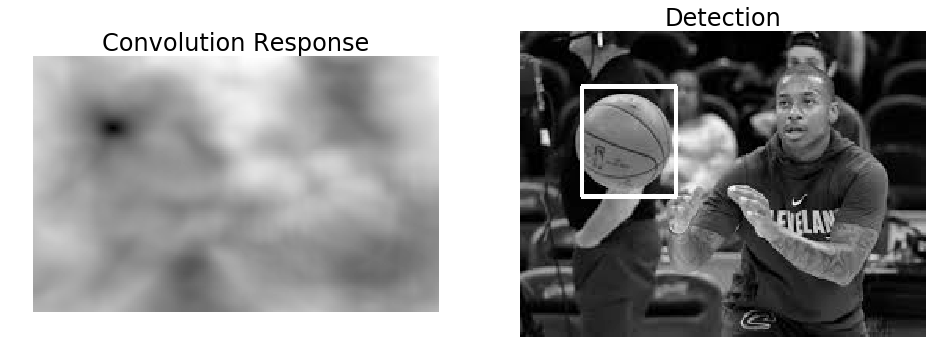

In [3]:
detect_features_opencv('images/target.jpg', 'images/template.jpg',
                      threshold=0.9)

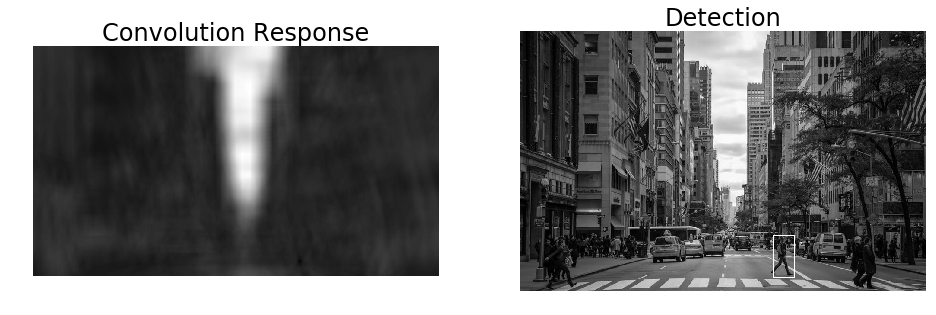

In [4]:
detect_features_opencv('images/target_street.jpg', 'images/template_human.jpg',
                      threshold=0.9)

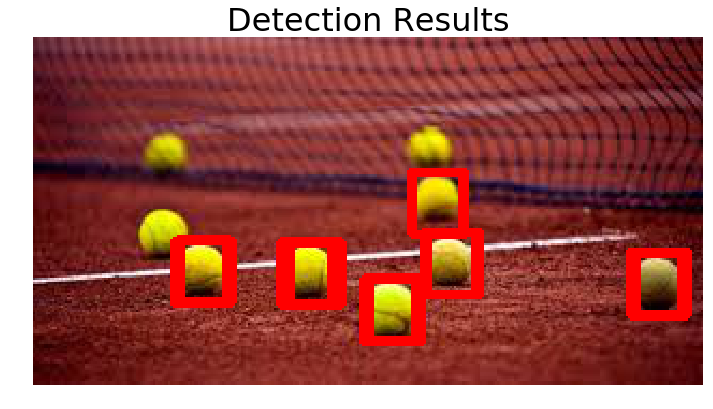

In [5]:
detect_features_opencv('images/target_tennis.jpg', 'images/template_tennis.jpg',
                      number = 'many', threshold = 0.8)

The `matchTemplate` function in openCV works very well both for finding a single occurrence and for finding many matches. However, it abstracts away most of the details, which does not give us a chance to learn what is actually happening. To solve that, we can do the same method but by hand. We are still abstracting away some of the details, mostly in the convolution, but this approach gives us slightly more insight into what `mathcTemplate` does for us.

## Implementation by Hand

This uses the Fast Fourier Transform Convolution in `scipy.signal` to find the response to the template within the target. Responses are normalized by the sum of responses for each individual color channel. 

### Normalization Functions

In [6]:
def _window_sum_2d(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - 
                 window_sum[:-window_shape[0] - 1])
    
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] -
                 window_sum[:, :-window_shape[1] - 1])
    
    return window_sum

In [7]:
def _window_sum_3d(image, window_shape):
    window_sum = _window_sum_2d(image, window_shape)
    
    window_sum = np.cumsum(window_sum, axis=2)
    window_sum = (window_sum[:, :, window_shape[2]:-1] - 
                  window_sum[:, :, :-window_shape[2] - 1])
    
    return window_sum

## Feature Detection Implementation

In [8]:
def detect_features(image_path, template_path, pad_input=True, 
                    mode='constant', constant_value=0):
    
    image = Image.open(image_path)
    image = np.array(image, dtype=np.float64, copy=False)

    orig_image = image.copy().astype(np.uint8)
    
    template = Image.open(template_path)
    template = np.array(template)
    
    if image.ndim < template.ndim:
        raise ValueError("Dimensionaliy of template must be less than or equal"
                         " to the dimensionality of image.")
    if np.any(np.less(image.shape, template.shape)):
        raise ValueError("Image must be larger than templtate")
        
    image_shape = image.shape
    
    pad_width = tuple((width, width) for width in template.shape)
    
    if mode == 'constant':
        image = np.pad(image, pad_width=pad_width, mode=mode,
                      constant_values=constant_value)
    else:
        image = np.pad(image, pad_width=pad_width, mode=mode)
        
    if image.ndim == 2:
        image_window_sum = _window_sum_2d(image, template.shape)
        image_window_sum2 = _window_sum_2d(image ** 2, template.shape)
        
    elif image.ndim == 3:
        image_window_sum = _window_sum_3d(image, template.shape)
        image_window_sum2 = _window_sum_3d(image ** 2, template.shape)
        
    template_mean = template.mean()
    template_volume = np.prod(template.shape)
    template_ssd = np.sum((template - template_mean) ** 2)
    
    if image.ndim == 2:
        xcorr = fftconvolve(image, template[::-1, ::-1],
                           mode='valid')[1:-1, 1:-1]
    elif image.ndim == 3:
        xcorr = fftconvolve(image, template[::-1, ::-1, ::-1],
                           mode = 'valid')[1:-1, 1:-1, 1:-1]
        
    # Normalization
    numerator = xcorr - image_window_sum * template_mean
    denominator = image_window_sum2
    np.multiply(image_window_sum, image_window_sum, out=image_window_sum)
    np.divide(image_window_sum, template_volume, out=image_window_sum)
    denominator = denominator - image_window_sum
    denominator = denominator * template_ssd
    np.maximum(denominator, 0, out=denominator)
    np.sqrt(denominator, out=denominator)
    
    response = np.zeros_like(xcorr, dtype=np.float64)
    
    mask = denominator > np.finfo(np.float64).eps
    
    response[mask] = numerator[mask] / denominator[mask]
    
    slices = []
    
    for i in range(template.ndim):
        if pad_input:
            d0 = (template.shape[i] - 1) // 2
            d1 = d0 + image_shape[i]
        else:
            d0 = template.shape[i] - 1
            d1 = d0 + image_shape[i] - template.shape[i] + 1
        slices.append(slice(d0, d1))
    
    return orig_image, template, response[slices]
        

## Model to Carry out the Procedure

In [9]:
def model(image_path, template_path, number = 'many', 
          threshold = 0.8, analyze = False):
    
    image, template, response = detect_features(image_path, template_path, 
                                               pad_input=True)
    
    if not analyze:
        plt.figure(figsize=(2, 2))
        ax1 = plt.subplot(1, 1, 1)
        ax1.imshow(template)
        ax1.set_axis_off()
        ax1.set_title('Template', size = 20)
        plt.show()
        fig, _ = plt.subplots(1, 2, figsize=(20, 8))
        ax2 = plt.subplot(121, adjustable = 'box-forced')
        ax3 = plt.subplot(122, sharex = ax2, sharey = ax2, adjustable = 'box-forced')
        
    else:
        plt.figure(figsize=(10, 10))
        ax2 = plt.subplot(111)
    
    ax2.imshow(image)
    ax2.set_axis_off()
    ax2.set_title('Target Image', size = 20)
        
    htemplate, wtemplate = template.shape[:2]
    
    if number == 'many':
        detections = 0
        
        pos = np.array(np.where(response[:, :, :] > threshold))
        
        recorded_boxes = [] 
        
        
        positions = []
        for position in range(pos.shape[1]):
            x, y, z = pos[:, position]
            value = response[x, y, z]
            positions.append((x, y, z, value))
            
        positions = sorted(positions, key = lambda x: x[3], reverse = True)
        
        for entry in positions:

            y, x = entry[:2]
            
            record = False
            
            for box in recorded_boxes:
                
                left, right, bottom, top = box
                
                if (x > left) & (x < right) & (y > bottom) & (y < top):
                    record = True
            
            if not record:
                rank = detections
                
                # left, right, bottom, top
                bounding_box = (x - wtemplate / 2, x + wtemplate / 2, 
                                y - htemplate / 2, y + htemplate / 2)

                recorded_boxes.append(bounding_box)

                rect = plt.Rectangle((x - wtemplate / 2, y - htemplate / 2), 
                                 wtemplate, htemplate, 
                                     edgecolor='r', facecolor='none', lw = 4)
                ax2.add_patch(rect)

                if not analyze:
                    ax3.plot(x,  y, marker = '$%d$' % (rank + 1), 
                             ms = 32, color = 'k', alpha = 0.6)

                detections += 1
        
        print('{} detections with threshold: {}\n'.format(detections, threshold))
    
    elif number == 'one':
        ij = np.unravel_index(np.argmax(response), response.shape)

        y, x = ij[:2]

        rect = plt.Rectangle((x - wtemplate / 2, y - htemplate / 2), 
                             wtemplate, htemplate, edgecolor='r', 
                             facecolor='none', lw = 4)
        ax2.add_patch(rect)
        circle = plt.Circle((x, y), radius = 6,  edgecolor='r',
                            facecolor='none', lw = 4)
        ax3.add_patch(circle)
    
    if not analyze:
        cax = ax3.imshow(response[:, :, 1], cmap=cm.coolwarm)
        fig.colorbar(cax, label = 'correlation', orientation = 'horizontal', 
                     shrink = 0.9, pad=0.05)
        ax3.set_axis_off()
        ax3.set_title('Response from Feature Detection', size = 20)
        ax3.autoscale(False)
        ax2.set_anchor('N')
        ax3.set_anchor('N')

    plt.show();

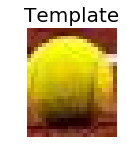

6 detections with threshold: 0.85



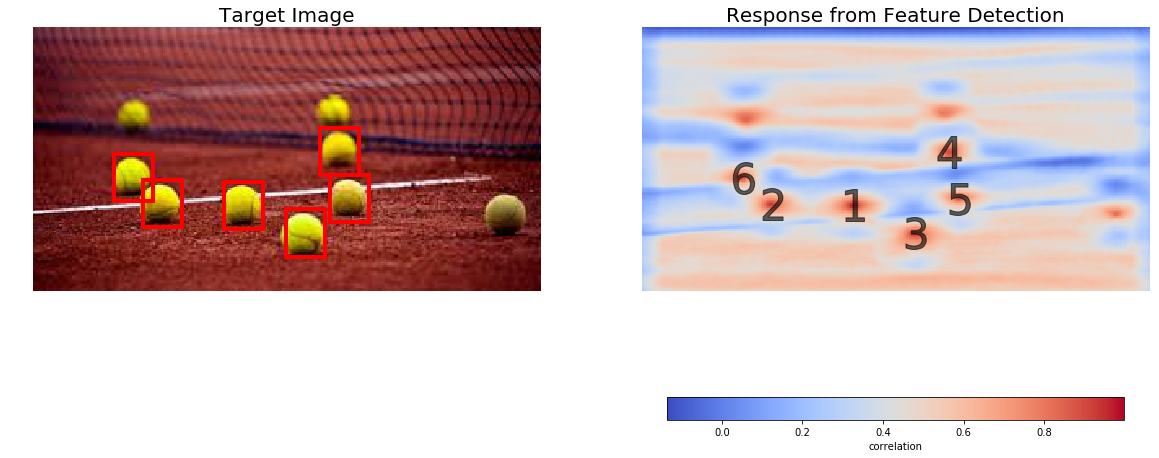

In [10]:
model(image_path = 'images/target_tennis.jpg', 
      template_path = 'images/template_tennis.jpg', threshold=0.85)

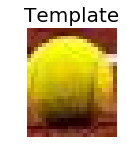

117 detections with threshold: 0.6



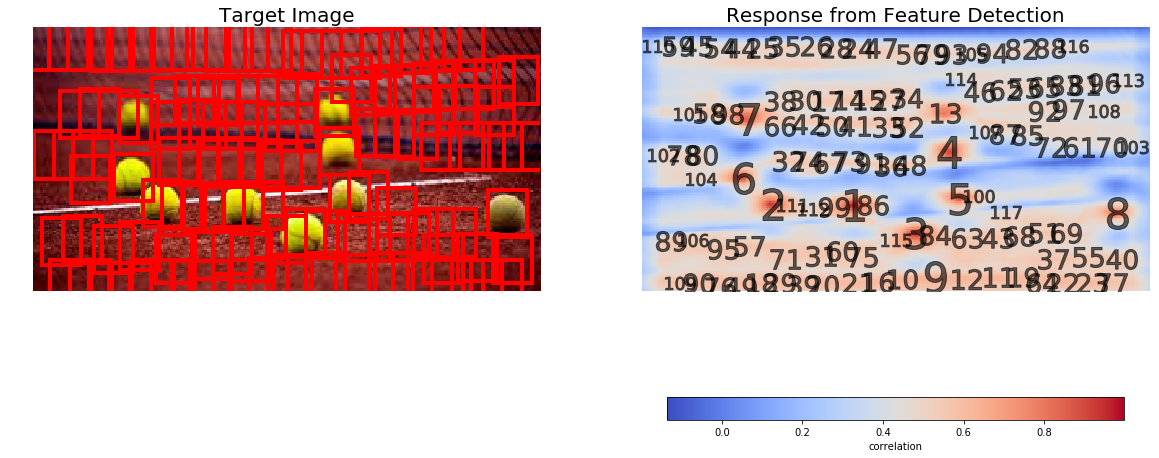

In [11]:
model(image_path = 'images/target_tennis.jpg', 
      template_path = 'images/template_tennis.jpg', threshold=0.6)

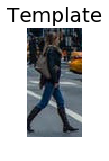

1 detections with threshold: 0.8



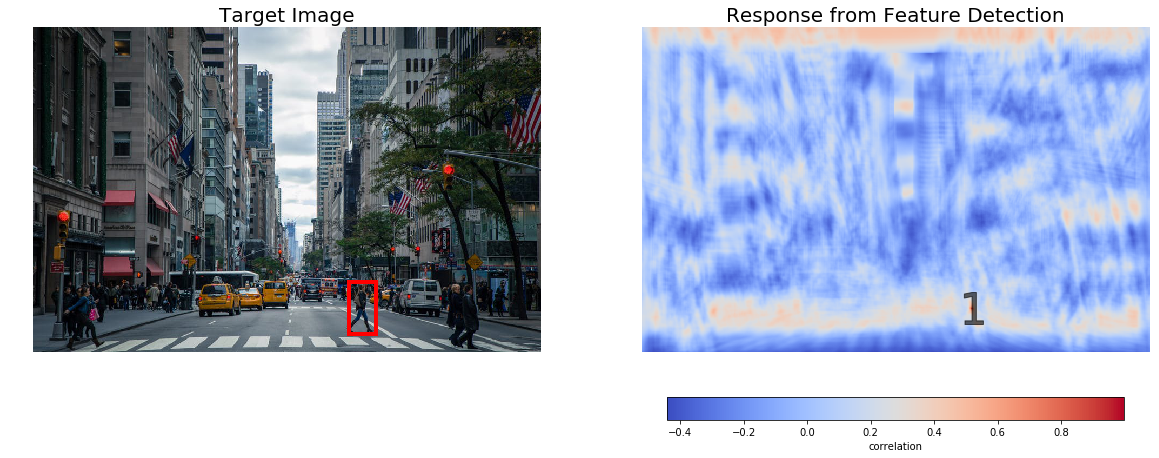

In [12]:
model(image_path = 'images/target_street.jpg', 
      template_path = 'images/template_human.jpg', threshold=0.8)

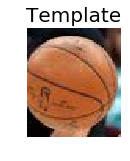

1 detections with threshold: 0.9



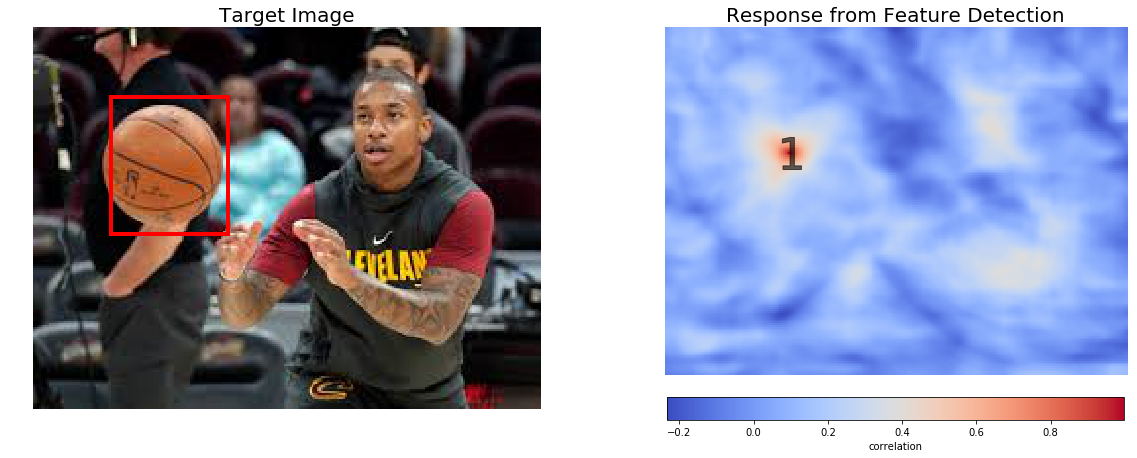

In [13]:
model(image_path = 'images/target.jpg', 
      template_path = 'images/template.jpg', threshold=0.9)

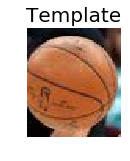

1 detections with threshold: 0.6



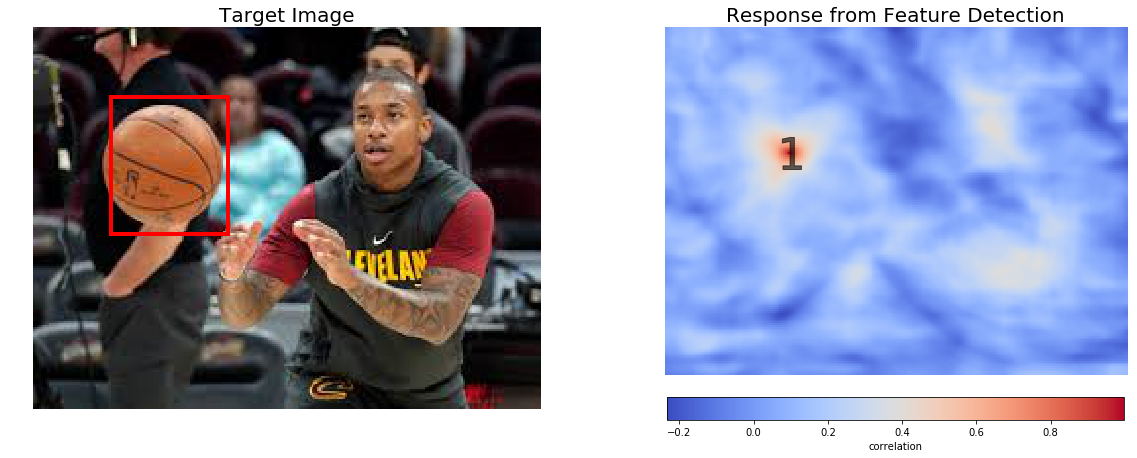

In [14]:
model(image_path = 'images/target.jpg', 
      template_path = 'images/template.jpg', threshold=0.6)

We can see that the model is sensitive to different thresholds especially when there are many occurrences of desired object within the image. Overall, the model performs well for the simple cases where there is only one clear case of the template object within the target but for multiple objects does not perform as well. One issue with this approach is using the same template to find objects that may be similar but not exactly identical. This is clearly the case here and this method would not work very well if we wanted to find many faces based on a single face. 

# Conclusions

We explored two implementations of template matching for feature detection: using openCV and a built-in function, and carrying out the same procedure ourselves one step at a time. Overall, the process is the same for this basic implementation:

1. Choose a template image with the object we want to detect in the target image.
2. Convolve the template image with the target image for each color channel.
3. Normalize the response in each individual color channel.
4. Find the highest response  (for a single occurrence), or all responses above a threshold (for multiple occurrences).
5. Conver the responses into integers between 0 and 255 and plot the results on the original image.
6. Compare the results with ground-truth, taken to be our opinion in this case, and adjust the threshold as needed.

In the next notebook, we will look at the ROC curve, how changing the threshold moves our location along a given ROC curve, and possible approaches for shifting the entire curve by modifying the signal to noise ratio. We will use the model built by hand for this exploration because it gives us more control over visualizing the results to assess the performance.